# Проект по оценки корректности A/B тестирования

<b>Цель исследования: </b><br>
провести оценку результатов A/B-теста. 

<b>Задача: </b><br>
1) оценить корректность проведения  теста:<br>
- удостоверься, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно;
- проверить равномерность распределения пользователей по тестовым группам и правильность их формирования.<br>

2) проанализировать результаты.

<b>Техническое задание: </b><br>
- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

<b>Ход исследования: </b>
1) Обзор данных.<br>

2) Предобработка данных:<br>
- поиск явных и неявных дубликатов;
- преобразование типов данных.

3) Проверка технического задания:<br>
- проверка времени проведения тестов (поиск максимальной и минимальной даты), сравнением с датами регистрации;
- проверка времени действий пользователя (максимальная дата 04.01.21);
- проверка активности пользователей (совершалось ли какое-нибудь событие за 14 дней)
- проверка оказания влияния маркетинговых акций на результаты теста;
- проверка количества новых пользователей в EU;
- проверка пересечений пользователей по тестам;
- проверка распределения пользователей по группам.

4) Исследовательский анализ данных:<br>
- посмотреть на распределение количества событий на пользователя в выборках (одинаково или нет);
- определить число событий в выборках по дням;
- посмотреть изменение конверсии в воронке в выборках на разных этапах.

5) Проведение и оценка A/B-тестирования:<br>
- выводу по результатам A/B-тестирования;
- проверить статистическую разницу долей z-критерием.

5) Подготовка промежуточного по исследовательскомиу анализу и проведенному A/B-тестированию.<br>

8) Общий вывод по проекту.

<b>Описание данных:</b>

Имеется 4 датасета:

1) <b>ab_project_marketing_events.csv</b> — календарь маркетинговых событий на 2020 год.

<b>name</b> — название маркетингового события;<br>
<b>regions</b> — регионы, в которых будет проводиться рекламная кампания;<br>
<b>start_dt</b> — дата начала кампании;<br>
<b>finish_dt</b> — дата завершения кампании.<br>

2) <b>final_ab_new_users.csv</b> — пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года.

<b>user_id</b> — идентификатор пользователя;<br>
<b>first_date</b> — дата регистрации;<br>
<b>region</b> — регион пользователя;<br>
<b>device</b> —  устройство, с которого происходила регистрация.<br>

3) <b>final_ab_events.csv</b> — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

<b>user_id</b> — идентификатор пользователя;<br>
<b>event_dt</b> — тип события;<br>
<b>details</b> — дополнительные данные о событии (например, для покупок, <b>purchase</b>, в этом поле хранится стоимость покупки в долларах).<br>

4) <b>final_ab_participants.csv</b> — таблица участников тестов.

<b>user_id</b> — идентификатор пользователя;<br>
<b>ab_test</b> — название теста;<br>
<b>group</b> — группа пользователя.<br>

### 1Обзор данных

In [1]:
#Подключим необходимые библиотеки
import pandas as pd
from datetime import datetime
from scipy import stats as st
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
import warnings

In [2]:
#задаем исходные настройки
warnings.filterwarnings("ignore")

In [3]:
#Загрузим данные
mark_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
ab_events = pd.read_csv('/datasets/final_ab_events.csv')
ab_particip = pd.read_csv('/datasets/final_ab_participants.csv')

In [4]:
#Базовая функция для ознакомления с данными: инфо о типах, пропусках, явных дубликатах
def show_data(df):
    display(df.head(15))
    print('-----')
    print('Информация о типах данных')
    df.info()
    print('-----')
    for col in df.columns:
        print('Название:', col, '\nПропусков:\t', df[col].isna().sum(), 'Процент пропусков:\t', round(df[col].isna().sum() *100 / len(df[col])))
    round(df[col].isna().sum() *100 / len(df[col]))
    print('-----')
    print('Явных дубликатов')
    print(df.duplicated().sum())

In [5]:
show_data(mark_events)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


-----
Информация о типах данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
-----
Название: name 
Пропусков:	 0 Процент пропусков:	 0
Название: regions 
Пропусков:	 0 Процент пропусков:	 0
Название: start_dt 
Пропусков:	 0 Процент пропусков:	 0
Название: finish_dt 
Пропусков:	 0 Процент пропусков:	 0
-----
Явных дубликатов
0


In [6]:
show_data(new_users)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
5,137119F5A9E69421,2020-12-07,N.America,iPhone
6,62F0C741CC42D0CC,2020-12-07,APAC,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
8,499AFACF904BBAE3,2020-12-07,N.America,iPhone
9,FFCEA1179C253104,2020-12-07,EU,Android


-----
Информация о типах данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
-----
Название: user_id 
Пропусков:	 0 Процент пропусков:	 0
Название: first_date 
Пропусков:	 0 Процент пропусков:	 0
Название: region 
Пропусков:	 0 Процент пропусков:	 0
Название: device 
Пропусков:	 0 Процент пропусков:	 0
-----
Явных дубликатов
0


In [7]:
show_data(ab_events)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99
6,6B2F726BFD5F8220,2020-12-07 11:27:42,purchase,4.99
7,BEB37715AACF53B0,2020-12-07 04:26:15,purchase,4.99
8,B5FA27F582227197,2020-12-07 01:46:37,purchase,4.99
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99


-----
Информация о типах данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
-----
Название: user_id 
Пропусков:	 0 Процент пропусков:	 0
Название: event_dt 
Пропусков:	 0 Процент пропусков:	 0
Название: event_name 
Пропусков:	 0 Процент пропусков:	 0
Название: details 
Пропусков:	 377577 Процент пропусков:	 86
-----
Явных дубликатов
0


In [8]:
show_data(ab_particip)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
5,4FF2998A348C484F,A,recommender_system_test
6,7473E0943673C09E,A,recommender_system_test
7,C46FE336D240A054,A,recommender_system_test
8,92CB588012C10D3D,A,recommender_system_test
9,057AB296296C7FC0,B,recommender_system_test


-----
Информация о типах данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
-----
Название: user_id 
Пропусков:	 0 Процент пропусков:	 0
Название: group 
Пропусков:	 0 Процент пропусков:	 0
Название: ab_test 
Пропусков:	 0 Процент пропусков:	 0
-----
Явных дубликатов
0


<b>Вывод: </b> Для анализа предоставлены 4 датасета:

1) <b>Календарь маркетинговых событий на 2020 год</b> содержит 14 мероприятий, явных дубликатов и пропусков не обнаружено, имеются столбцы с информацией о дате с некорректным форматом, который будет переопределен на этапе предобработки.<br>

2) Массив данных о <b>пользователях, зарегистрировавшиеся с 7 до 21 декабря 2020 года</b> содержит информацию о 617330 участниках, явных дубликатов и пропусков также не обнаружено, имеется столбец с информацией о дате с некорректным форматом, который будет переопределен на этапе предобработки.<br>

3) Данные о <b>действиях новых пользователей в период с 7 декабря 2020 по 4 января 2021 года</b> содержит информацию о 440317 действий, явных дубликатов не обнаружено, имеется большой процент пропусков (86%) по столбцу <b>details</b>, но т.к. данная информация не является обязательной для заполнения и необходимой для анализа, прорабатывать дополнительно и заполнять/удалять такие пропуски не будем. Также имеются столбцы с информацией о дате с некорректным форматом, который будет переопределен на этапе предобработки.<br>

4) <b>Таблица участников тестов</b> содержит 18 268 пользователей, явных дубликатов и пропусков не обнаружено.

В ходе предобработки данных массивы будут дополнительно проверены на неявных дубликаты.

### 2. Предобработка данных

In [9]:
#анализ уникальных значений по new_users
print('Уникальные значения по столбцу region:', new_users['region'].unique())
print('Уникальные значения по столбцу device:', new_users['device'].unique())

Уникальные значения по столбцу region: ['EU' 'N.America' 'APAC' 'CIS']
Уникальные значения по столбцу device: ['PC' 'Android' 'iPhone' 'Mac']


In [10]:
#анализ уникальных значений по ab_events
print('Уникальные значения по столбцу event_name:', ab_events['event_name'].unique())

Уникальные значения по столбцу event_name: ['purchase' 'product_cart' 'product_page' 'login']


In [11]:
#анализ уникальных значений по ab_particip
print('Уникальные значения по столбцу region:', ab_particip['group'].unique())
print('Уникальные значения по столбцу device:', ab_particip['ab_test'].unique())

Уникальные значения по столбцу region: ['A' 'B']
Уникальные значения по столбцу device: ['recommender_system_test' 'interface_eu_test']


In [12]:
#поиск дубликатов user_id по new_users
print('Количество уникальных пользователей:', new_users['user_id'].nunique())
print('Количество дубликатов среди пользователей:', new_users['user_id'].duplicated().sum())

Количество уникальных пользователей: 61733
Количество дубликатов среди пользователей: 0


Неявных дубликатов не выявлено. Среди новых пользователей также нет повторений. 

<u><b>Преобразование типов данных

In [13]:
#преобразование столбцов с датами по mark_events
mark_events['start_dt'] = pd.to_datetime(mark_events['start_dt'])
mark_events['finish_dt'] = pd.to_datetime(mark_events['finish_dt'])
mark_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [14]:
#преобразование столбцов с датами по new_users
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


In [15]:
#преобразование столбцов с датами по new_users
ab_events['event_dt'] = pd.to_datetime(ab_events['event_dt'])
ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


<b>Вывод: </b> в ходе предобработке данных была проведена дополнительная проверка на наличие неявных дубликатов, которая показала отсутствии таких. Среди новых пользователей также нет повторений. Были изменены форматы столбцов по всем массивам, содержащие информацию о дате. Таким столбцам был присвоен тип `data`.

### 3. Проверка технического задания

Для удобства проведения анализа (чтобы ничего лишнего не убрать и наоборот не оставить) объединим исходные таблицы.

In [16]:
df = new_users.merge(ab_events, how = 'left', on = 'user_id')
df = df.merge(ab_particip, how = 'left', on = 'user_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 449956 entries, 0 to 449955
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     449956 non-null  object        
 1   first_date  449956 non-null  datetime64[ns]
 2   region      449956 non-null  object        
 3   device      449956 non-null  object        
 4   event_dt    446211 non-null  datetime64[ns]
 5   event_name  446211 non-null  object        
 6   details     63588 non-null   float64       
 7   group       110368 non-null  object        
 8   ab_test     110368 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 34.3+ MB


Выберем данные только по тесту `recommender_system_test`

In [17]:
df = df[df['ab_test'] == 'recommender_system_test']
df.head()

,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:10,product_page,NaN,A,recommender_system_test
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:07,login,NaN,A,recommender_system_test
90,E6DE857AFBDC6102,2020-12-07,EU,PC,NaT,NaN,NaN,B,recommender_system_test
146,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-07 15:32:54,product_page,NaN,B,recommender_system_test
148,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-08 08:29:31,product_page,NaN,B,recommender_system_test


<u><b>Проверка времени проведения тестов

Сверим даты начала и окончания регистрации пользователей с датой проведения теста по ТЗ

In [18]:
print('Дата начала регистрации пользователей:', df['first_date'].min())
print('Дата окончания регистрации пользователей:', df['first_date'].max())

Дата начала регистрации пользователей: 2020-12-07 00:00:00
Дата окончания регистрации пользователей: 2020-12-21 00:00:00


Дата запуска теста совпадает с датой начала регистрации новых пользователей - 07.12.2020. Дата окончания набора новых пользователей также соответствует ТЗ - 21.12.2020.

<u><b>Проверка даты последнего действия пользователей

Сверим финальную дату проведения события с датой остановки теста по ТЗ

In [19]:
print('Дата последнего действия пользователей:', df['event_dt'].max())

Дата последнего действия пользователей: 2020-12-30 12:42:57


Последнее действие, которое совершали пользователи было 30.12.2020, хотя в ТЗ указана дата - 04.01.2021. Возможно это связано с человеческим фактором и данные не были внесены или проведением каких-либо праздничных акции. Последний фактор проверим дополнительно.

In [20]:
mark_events.sort_values(by='start_dt', ascending = False)

,name,regions,start_dt,finish_dt
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07
4,4th of July Promo,N.America,2020-07-04,2020-07-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19


В последние дни декабря были проведены новогодние акции, возможно причина даты остановки именно в этом.

<b><u>Проверка активности пользователей (совершалось ли какое-нибудь событие за 14 дней)

Отсечем пользователей, которые совершили первое события за чертой 14 дней после регистрации. Для этого добавим новый столбец.

In [21]:
#количество пользователей до фильтрации
print('Количество пользователей до фильтрации:', 
      df['user_id'].nunique())
df.groupby('group').agg({'user_id':'nunique'}).reset_index()

Количество пользователей до фильтрации: 6701


,group,user_id
0,A,3824
1,B,2877


In [22]:
#добавим столбец только с датой события 
df['event_date'] = df['event_dt'].dt.date

#выделем только дату из даты регистрации
df['first_dt'] = df['first_date'].dt.date

#Добавим столбец с подсчетом дней от даты регистрации до даты первого события
df['first_ev'] = (df['event_date'] - df['first_dt']).dt.days
df.head(10)

,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test,event_date,first_dt,first_ev
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:10,product_page,NaN,A,recommender_system_test,2020-12-07,2020-12-07,0.0
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:07,login,NaN,A,recommender_system_test,2020-12-07,2020-12-07,0.0
90,E6DE857AFBDC6102,2020-12-07,EU,PC,NaT,NaN,NaN,B,recommender_system_test,NaT,2020-12-07,NaN
146,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-07 15:32:54,product_page,NaN,B,recommender_system_test,2020-12-07,2020-12-07,0.0
148,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-08 08:29:31,product_page,NaN,B,recommender_system_test,2020-12-08,2020-12-07,1.0
150,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-10 18:18:27,product_page,NaN,B,recommender_system_test,2020-12-10,2020-12-07,3.0
152,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-16 20:35:48,product_page,NaN,B,recommender_system_test,2020-12-16,2020-12-07,9.0
154,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-18 23:57:25,product_page,NaN,B,recommender_system_test,2020-12-18,2020-12-07,11.0
156,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-30 12:42:57,product_page,NaN,B,recommender_system_test,2020-12-30,2020-12-07,23.0
158,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-07 15:32:53,login,NaN,B,recommender_system_test,2020-12-07,2020-12-07,0.0


In [23]:
#отсечем пользователей, выходящих за период в 14 дней
df = df.loc[df['first_ev'] <= 14]

Посмотрим на количество пользователей, которые совершили какое-либо событие за 14 дней, и на их распределение по группам.

In [24]:
print('Количество пользователей, которые подходят под критерии провидения теста:', 
      df['user_id'].nunique())
df.groupby('group').agg({'user_id':'nunique'}).reset_index()

Количество пользователей, которые подходят под критерии провидения теста: 3675


,group,user_id
0,A,2747
1,B,928


<u><b>Проверка оказания влияния маркетенговых акций на результаты теста

Проверим входят ли какие-либо маркетенговые акции в период проведения нашего теста

In [25]:
#проверка на окончание акции во время теста
ev_end = mark_events[mark_events['finish_dt'] > '2020-12-07']
ev_end = ev_end[mark_events['start_dt'] < '2020-12-07']
ev_end

,name,regions,start_dt,finish_dt


Ни одна акция не заканчивалась во время провидения теста. Посмотрим входила ли какая-либо акция в наш тест целиком

In [26]:
#проверка на полное вхождение акции во время теста
ev_full = mark_events[mark_events['finish_dt'] > '2020-12-07']
ev_full = ev_full[mark_events['finish_dt'] < '2021-01-04']
ev_full

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Новогодня акция вошла в промежуток проведения теста полностью, что конечно скажется на результатах исследования.
Проверим, входит ли какое-либо начало проведения акции в наш тест.

In [27]:
#проверка на начало акции во время теста
ev_start = mark_events[mark_events['start_dt'] < '2021-01-04']
ev_start = ev_start[mark_events['finish_dt'] > '2021-01-04']
ev_start

,name,regions,start_dt,finish_dt
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Во время проведения теста вошла новогодня лотерия, но она проводилась не в регионе исследования. Такая акция влияния на исследование не окажет.

<div style="text-align: justify ">
<b>Краткий итого по датам проведения теста:</b> при проверке ТЗ и времени проведения теста можно сделать вывод, что начало проведения теста совпадает с началом регистрации новых пользователей и соответствует ТЗ. Дата окончания регистрации также соответствует заявленному в ТЗ. Однако время окончания теста, заявленного в ТЗ, не соответствует дате последнего события, сделанного пользователем. Этот фактор может оказать влияние на результаты теста. Дополнительно была проведена фильтрация по периоду проведения теста. Пользователи, которые совершили первое событие после 14 дней, были отсечены. В тест вошли 3 675 пользователя. Также важно отметить время проведения теста - это предновогодний период, который подразумевает собой активность пользователей при подготовке к праздникам. Дополнительно еще была проведена новогодняя маркетинговая акция. Результаты могут быть не информативными.

<b><u>Проверка количества новых пользователей в EU

Посмотрим на итоговое распределение пользователей по регионам.

In [28]:
info_user = new_users.groupby('region').agg({'user_id': 'nunique'}).reset_index()
info_user = info_user.rename(columns={'user_id':'count'})
info_user

,region,count
0,APAC,3153
1,CIS,3155
2,EU,46270
3,N.America,9155


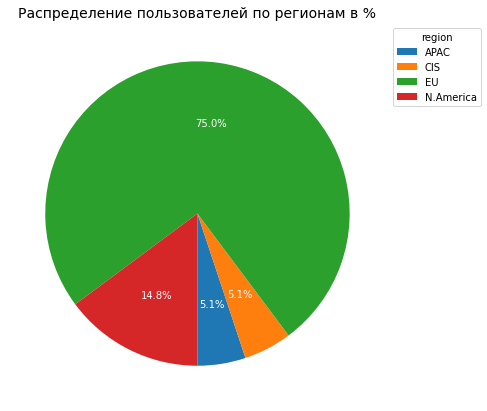

In [29]:
#построим круговую диаграмму распреледения пользователей
fig1,ax1 = plt.subplots(figsize =(15,7))
ax1.pie(info_user['count'], labels=info_user['region'], autopct='%.1f%%', startangle = 270, textprops=dict(color="w"))
ax1.legend(
title='region',
bbox_to_anchor=(1, 0, 0, 1))
ax1.set_title(f'Распределение пользователей по регионам в %', fontsize = 14)
plt.show()

Из диаграммы видно, что больше всего пользователей из Европы.

Посмотрим как распределяются пользователи уже в отфильтрованных данных.

In [30]:
print('Всего пользователей в тесте:', df['user_id'].nunique())
info_user_filt = df.groupby('region').agg({'user_id': 'nunique'}).reset_index()
info_user_filt = info_user_filt.rename(columns={'user_id':'count'})
info_user_filt

Всего пользователей в тесте: 3675


,region,count
0,APAC,45
1,CIS,30
2,EU,3481
3,N.America,119


Доля пользователей увеличилась еще сильнее. Удалять пользователей из теста не будем, т.к. их достаточно мало

Проверим данные на соответствие ТЗ: количество новых пользователей - 15%.

In [31]:
#установим максимальную дату привлечения новых пользователей
max_dt_new_users = new_users[new_users['first_date'] <= '2020-12-21']
max_dt_new_users['first_date'].max()

Timestamp('2020-12-21 00:00:00')

In [32]:
#посчитаем процент новых пользователей
perc_new_users_EU = (df[df['region'] == 'EU']['user_id'].
                     nunique())/(max_dt_new_users[max_dt_new_users['region'] == 'EU']['user_id'].nunique())

print('Доля новых пользователей из региона EU составляет - {:.2%}'.format(perc_new_users_EU))

Доля новых пользователей из региона EU составляет - 8.22%


<b>Краткий вывод:</b> После фильтрации по периоду проведения исследования, в тесте принимают участие 3 675 пользователей. Большая часть участников из Европы. Доля новых пользователей региона EU составляет 8,22%, что не соответствует заявленной доли в ТЗ (15%).

<u><b>Проверка пересечений пользователей по тестам

In [33]:
ab_particip['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

Важно заметить, что кроме нашего теста проводится еще один. Неоходимо проверить, если пересечения пользователей по двум группам.

In [34]:
#поиск пересечений user_id по ab_particip
print('Количество уникальных пользователей:', ab_particip['user_id'].nunique())
print('Количество пересечений пользователей по тестам:', ab_particip['user_id'].duplicated().sum())

Количество уникальных пользователей: 16666
Количество пересечений пользователей по тестам: 1602


In [35]:
#просмотр пользователей, попавших в оба теста
both_test_users = (ab_particip[ab_particip['user_id'].duplicated(keep=False)].
                   sort_values(by='user_id', ascending=True))
both_test_users.head(10)

,user_id,group,ab_test
17892,001064FEAAB631A1,B,interface_eu_test
235,001064FEAAB631A1,B,recommender_system_test
16961,00341D8401F0F665,A,interface_eu_test
2137,00341D8401F0F665,A,recommender_system_test
8143,003B6786B4FF5B03,A,interface_eu_test
3156,003B6786B4FF5B03,A,recommender_system_test
4768,0082295A41A867B5,A,recommender_system_test
14161,0082295A41A867B5,B,interface_eu_test
15562,00E68F103C66C1F7,B,interface_eu_test
4074,00E68F103C66C1F7,A,recommender_system_test


Наблюдется пересесечение в двух тестах. В обоих тестах участвуют 1 602 пользователя. Необходимо просмотреть на распределение пользователей группы B конкурирующего теста на группы A и B нашего теста.

In [36]:
#посмотрим на количество пользователей группы B конкурирующего теста
both_test_users_B = both_test_users[both_test_users['ab_test'] == 'interface_eu_test']
both_test_users_B = both_test_users_B[both_test_users_B['group'] == 'B']
print('Количество пользователей группы B конкурирующего теста:', both_test_users_B['user_id'].count())

Количество пользователей группы B конкурирующего теста: 783


Найдем пользователей, которые участвуют в двух тестах, и посмотрим как происходит распределение между группами нашего теста. 

In [37]:
#поиск пользователей, участвующи в двух тестах одновременно
test_users_B_in_contr = ab_particip[ab_particip['user_id'].isin(both_test_users_B['user_id'].values)]
test_users_B_in_contr.sort_values(by='user_id', ascending=True).head(10)

,user_id,group,ab_test
235,001064FEAAB631A1,B,recommender_system_test
17892,001064FEAAB631A1,B,interface_eu_test
4768,0082295A41A867B5,A,recommender_system_test
14161,0082295A41A867B5,B,interface_eu_test
4074,00E68F103C66C1F7,A,recommender_system_test
15562,00E68F103C66C1F7,B,interface_eu_test
15682,010DB4614355A4BB,B,interface_eu_test
6055,010DB4614355A4BB,B,recommender_system_test
797,020A95B66F363AFB,B,recommender_system_test
14742,020A95B66F363AFB,B,interface_eu_test


In [38]:
#выберем пользователей контрольного теста
test_contr = test_users_B_in_contr[test_users_B_in_contr['ab_test'] == 'recommender_system_test']
test_contr['ab_test'].unique()

array(['recommender_system_test'], dtype=object)

<div style="text-align: justify ">
Посмотрим на распределение участников группы B конкурирующего теста на группы A и B контрольного теста. Дополнительно проверим распределение на нормальность z-test и проверим гипотезу о равенстве пропорций пользователей из группы В конкурирующего теста в группе А и группе В контрольного теста:

In [39]:
#распределение пользователей группы B конкурирующего теста на группы A и B контрольного теста
test_contr = test_contr.groupby(['ab_test', 'group']).agg({'user_id': 'count'}).reset_index()
test_contr

,ab_test,group,user_id
0,recommender_system_test,A,439
1,recommender_system_test,B,344


In [40]:
#распределение пользователей контрольного теста между группами A и B 
ab_particip_contr = ab_particip[ab_particip['ab_test'] == 'recommender_system_test']
print('Количество пользователей в контрольном тесте:', ab_particip_contr['user_id'].count())
ab_particip_contr = ab_particip_contr.groupby(['ab_test', 'group']).agg({'user_id': 'count'}).reset_index()
ab_particip_contr

Количество пользователей в контрольном тесте: 6701


,ab_test,group,user_id
0,recommender_system_test,A,3824
1,recommender_system_test,B,2877


In [41]:
#проверим процент присутсвтия пользователей группы B конкурирующего теста в группах контрольного теста
print('Доля присутствия в группе A: {:.2%}'.format(439/3824))
print('Доля присутствия в группе B: {:.2%}'.format(344/2877))

Доля присутствия в группе A: 11.48%
Доля присутствия в группе B: 11.96%


Видно, что процент попадания группы В конкурирующего теста в группы контрольного теста практически одинаковый - разница менее 0,5 п.п.

Дополнительно посчитаем статистическую значимость различий между группами A и B с учатсниками из конкурирующего теста.

Сформулируем гипотезы:
Нулевая $H_{0}$: значимых различий между долями нет, различия статистически не значимы. 

Альтернативная $H_{1}$: значимые различия между долями есть.

In [42]:
# критический уровень статистической значимости
alpha = 0.05  

group_A = test_contr.loc[test_contr['group'] == 'A', 'user_id'].values[0]
group_B = test_contr.loc[test_contr['group'] == 'B', 'user_id'].values[0]

group_A_contr = ab_particip_contr.loc[ab_particip_contr['group'] == 'A', 'user_id'].values[0]
group_B_contr = ab_particip_contr.loc[ab_particip_contr['group'] == 'B', 'user_id'].values[0]


p1 = group_A / group_A_contr
p2 = group_B / group_B_contr

p_combined = (group_A + group_B) / (group_A_contr + group_B_contr)

difference = p1 - p2 

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group_A_contr + 1/group_B_contr)) # ваш код

distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2


print('p-значение: ', p_value)

if p_value < alpha:
    print('Между долями есть значимая разница')
else:
    print(
        'Нет оснований считать доли разными'
    )

p-значение:  0.5475925169519402
Нет оснований считать доли разными


<div style="text-align: justify ">
Как видно из проведенного теста, распределение участников группы B конкурирующего теста на группы A и B контрольного теста равномерное и нормально. Таким образом, можно сделать вывод, что пользователи из группы B конкурирующего теста не окажут влияния на результаты проведения нашего теста. Удалять таких пользователей не будем. Всего в тесте принимают участие 6 701 пользователь, в группе A - 3 842, в группе B - 2 877.

<b><u>Проверка распределения пользователей по группам контрольного теста

In [43]:
ab_particip_contr.groupby('user_id').agg({'group':'nunique'}).reset_index()

,user_id,group
0,2877,1
1,3824,1


Видно, что среди групп нет пользователей, которые были бы в обеях группах.

In [44]:
ab_particip_contr

,ab_test,group,user_id
0,recommender_system_test,A,3824
1,recommender_system_test,B,2877


<b>Вывод по проверке ТЗ:</b> В ходе проверки технического задания было обнаружено следующее:

<b>1) в части даты проведения теста:</b>
- начало проведения теста совпадает с началом регистрации новых пользователей и соответствует ТЗ;
- дата окончания регистрации также соответствует заявленному в ТЗ. Однако время окончания теста, заявленного в ТЗ, не соответствует дате последнего события, сделанного пользователем;
- была проведена фильтрация по периоду проведения теста. Пользователи, которые совершили первое событие после 14 дней, были отсечены;
- важно отметить время проведения теста - это предновогодний период, который подразумевает собой активность пользователей при подготовке к праздникам. Дополнительно еще была проведена новогодняя маркетинговая акция. Результаты могут быть не информативными.

<b>2) В части проверки количества новых пользователей:</b>
- после фильтрации по периоду проведения исследования, в тесте принимают участие 3 675 пользователей. Большая часть участников из Европы. Доля новых пользователей региона EU составляет 8,22%, что не соответствует заявленной доли в ТЗ (15%).

<b>3) в части пересечения пользователя по тестам:</b>
- в ходе проверки пересечения участия пользователей в двух тестах было обнаружено, что в обоих тестах участвуют 1 602 пользователя. Было обнаружено, что в группе В конкурирующего теста принимали участие 783 пользователя. Распределение таких пользователей на группы А и В контрольного теста равномерное. Таким образом удалять таких пользователей не стали. 
- пересечение среди участников групп А и В контрольного теста не обнаружено.



### 4. Исследовательский анализ данных

<b><u>Распределение количества событий по дате

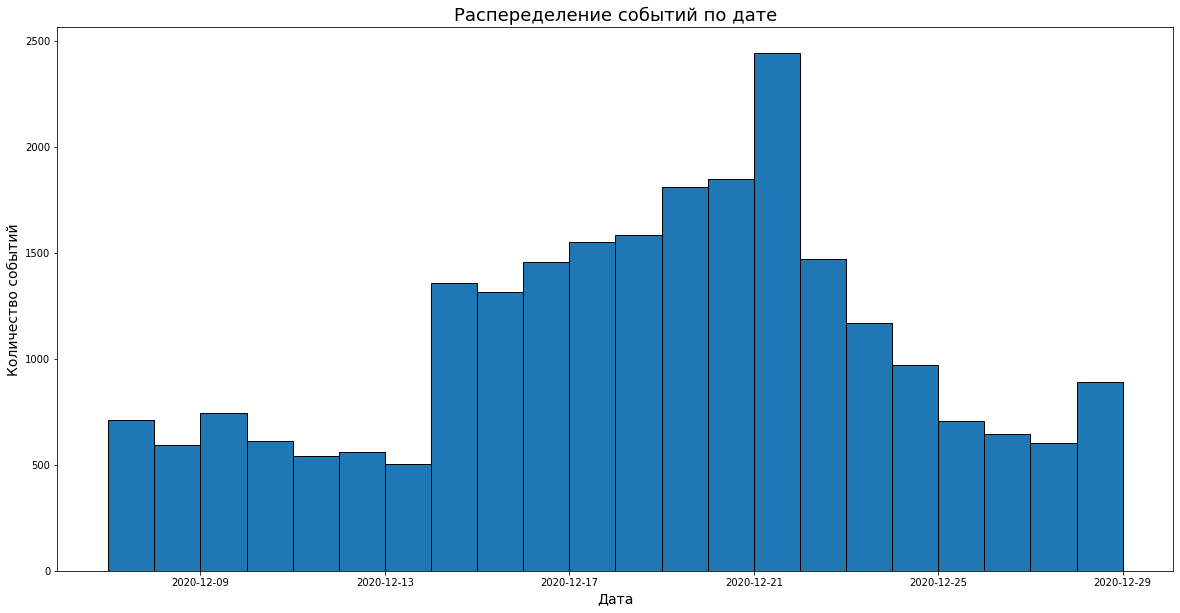

In [45]:
#построим гистограмму распределения событий по дате
plt.figure(figsize=(20,10)) 
df['event_date'].hist(bins=22, edgecolor='black', grid=False)
plt.title(f'Распеределение событий по дате', fontsize = 18)
plt.ylabel('Количество событий', fontsize = 14)
plt.xlabel('Дата', fontsize = 14)
plt.show()

Из диаграммы видно, что всплеск активности происходит в период с 15.12 по 23.12 с пиком на 22.12. Опять таки, скорее всего это связано с предрождественской активностью.

In [46]:
df_ev_dt = df[df['event_dt'] < '2020-12-22'].sort_values(by='event_dt')
df_ev_dt['event_dt'].max()

Timestamp('2020-12-21 23:59:39')

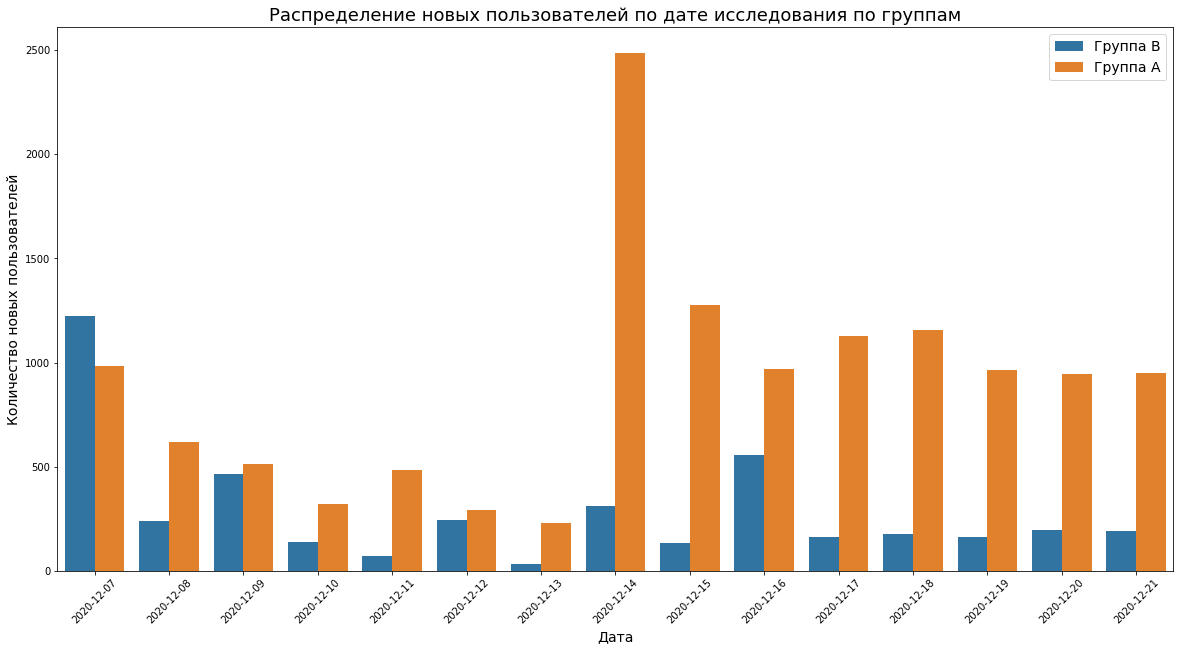

In [47]:
#построим гистограмму распределения пользователей групп по дням исследования по группам
plt.figure(figsize=(20,10)) 
ax = sns.countplot(data=df_ev_dt, x='first_dt', hue='group');
plt.title('Распределение новых пользователей по дате исследования по группам', fontsize = 18)
plt.legend(['Группа B', 'Группа A'], fontsize = 14)
plt.ylabel('Количество новых пользователей', fontsize = 14)
plt.xlabel('Дата', fontsize = 14)
plt.xticks(rotation = 45)
plt.show()  

<div style="text-align: justify ">
    Видно, что в первый день новых пользователей больше по группе В, однако, начиная со второго дня новых пользователей группы А стабильно больше. Пик набора новых пользователей группы В приходится на 07.12, группы А на 14.12, причем он почти в два раза больше. После 16.12 регистрация новых пользователей идет ровно. Количество новых пользователей группы А в разы превышает количество группы В.

<b><u>Распределение событий, совершенных пользователями впервые, по периоду исследования

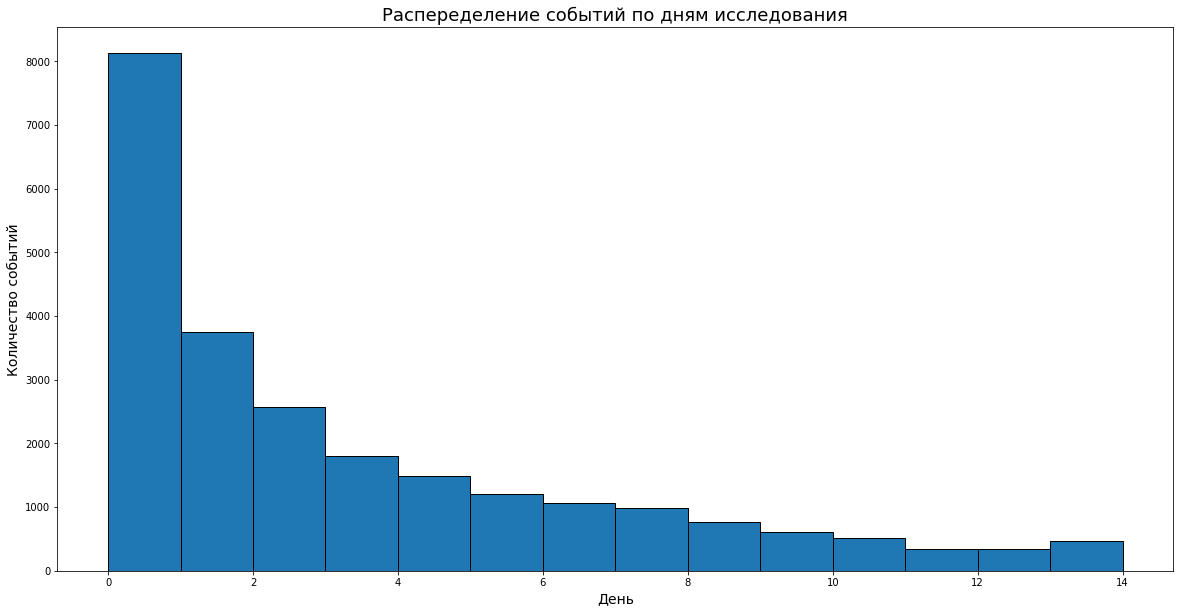

In [48]:
#построим гистограмму распределения событий по дням исследования
plt.figure(figsize=(20,10)) 
df['first_ev'].hist(bins=14, edgecolor='black', grid=False)
plt.title(f'Распеределение событий по дням исследования', fontsize = 18)
plt.ylabel('Количество событий', fontsize = 14)
plt.xlabel('День', fontsize = 14)
plt.show()

Из графика видно, что большинство пользователей совершают первое событие в первый день. Далее по нисходящей.

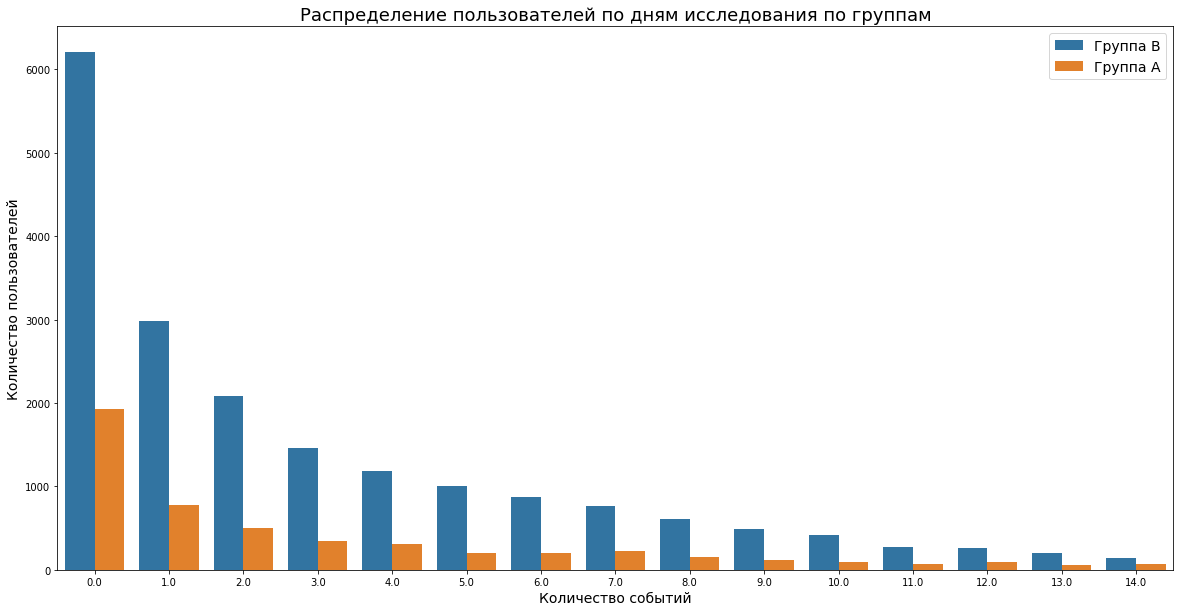

In [49]:
#построим гистограмму распределения пользователей групп по дням исследования по группам
plt.figure(figsize=(20,10)) 
ax = sns.countplot(data=df, x='first_ev', hue='group');
plt.title(f'Распределение пользователей по дням исследования по группам', fontsize = 18)
plt.legend(['Группа B', 'Группа A'], fontsize = 14)
plt.ylabel('Количество пользователей', fontsize = 14)
plt.xlabel('Количество событий', fontsize = 14)
plt.show()  

<b><u>Расчет среднего количества событий на одного пользователя

Ранее уже был произведен анализ распределения пользователей по группам теста, которое показало, что рапределение между группами совсем неравномерное.

In [50]:
df.groupby('group').agg({'user_id':'nunique'}).reset_index()

,group,user_id
0,A,2747
1,B,928


Найдем среднее количество событий на одного пользователя

In [51]:
events_per_user = pd.pivot_table(df, index = ['user_id','group'], values = ['device'], aggfunc={'count'})
events_per_user.columns = events_per_user.columns.droplevel(0)
events_per_user = events_per_user.rename(columns={'device':'count'}).reset_index()
events_per_user.head(10)

,user_id,group,count
0,001064FEAAB631A1,B,6
1,0010A1C096941592,A,12
2,00341D8401F0F665,A,2
3,003DF44D7589BBD4,A,15
4,00505E15A9D81546,A,5
5,005E096DBD379BCF,B,4
6,006E3E4E232CE760,A,6
7,0082295A41A867B5,A,20
8,00A52DCF85F1BE03,A,2
9,00C1F5175586DFCF,A,9


In [52]:
round(events_per_user['count'].describe(),2)

count    3675.00
mean        6.55
std         3.76
min         1.00
25%         4.00
50%         6.00
75%         9.00
max        24.00
Name: count, dtype: float64

В среднем пользователь по двум группам совершает почти 7 событий (6,55), медианное значение равно 6. Максимальное количество событий - 24.

In [53]:
#найдем среднее количество событий на одного пользователя группы А
events_per_user_A = events_per_user[events_per_user['group'] == 'A']
round(events_per_user_A['count'].describe(),2)

count    2747.00
mean        6.90
std         3.84
min         1.00
25%         4.00
50%         6.00
75%         9.00
max        24.00
Name: count, dtype: float64

В среднем пользователь группы А совершает также почти 7 событий, но значение чуть больше (6,90), медианное значение также равно 6. Максимальное количество событий - 24.

In [54]:
#найдем среднее количество событий на одного пользователя группы В
events_per_user_B = events_per_user[events_per_user['group'] == 'B']
round(events_per_user_B['count'].describe(),2)

count    928.00
mean       5.52
std        3.30
min        1.00
25%        3.00
50%        4.00
75%        8.00
max       24.00
Name: count, dtype: float64

В среднем пользователь группы B совершает меньше событий - 5,5, медианное значение равно 4. Максимальное количество событий - 24.

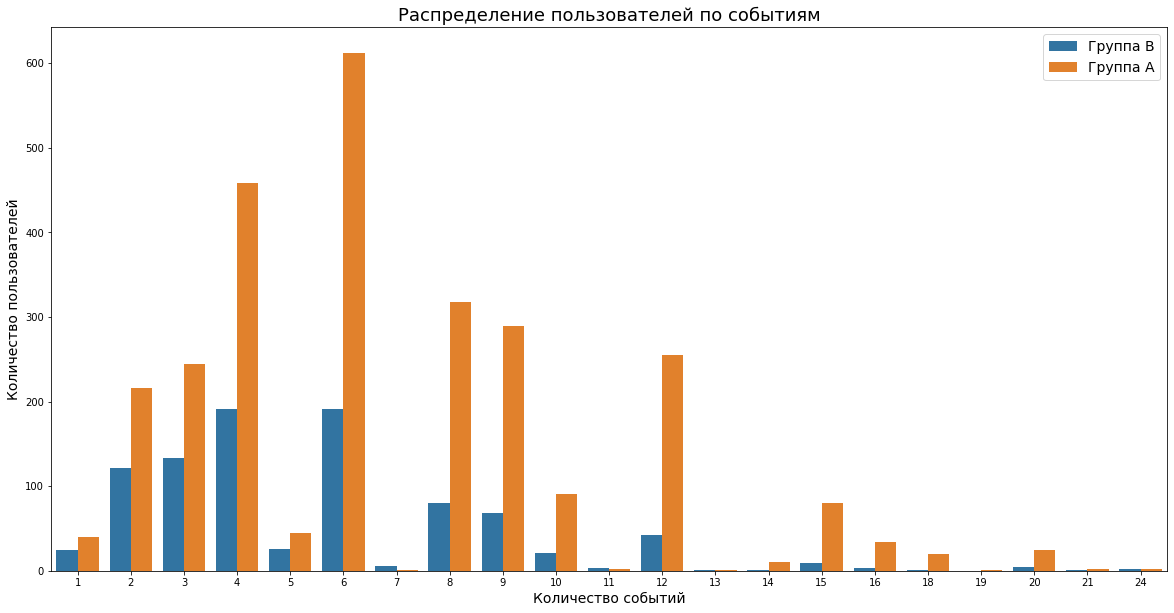

In [55]:
#построим гистограмму распределения пользователей по событиям
plt.figure(figsize=(20,10)) 
ax = sns.countplot(data=events_per_user, x='count', hue='group');
plt.title(f'Распределение пользователей по событиям', fontsize = 18)
plt.legend(['Группа B', 'Группа A'], fontsize = 14)
plt.ylabel('Количество пользователей', fontsize = 14)
plt.xlabel('Количество событий', fontsize = 14)
plt.show()  

График подтверждает, что пользователи группы А совершают событий больше.

<b><u>Распределение пользователей по устройствам

In [56]:
events_per_diveces = pd.pivot_table(df, index = ['device','group'], values = ['user_id'], aggfunc={'nunique'})
events_per_diveces.columns = events_per_diveces.columns.droplevel(1)
events_per_diveces = events_per_diveces.rename(columns={'user_id':'count'}).reset_index()
events_per_diveces

,device,group,count
0,Android,A,1197
1,Android,B,428
2,Mac,A,270
3,Mac,B,76
4,PC,A,726
5,PC,B,227
6,iPhone,A,554
7,iPhone,B,197


Видно, что по устройствам пользователей группы В также сильно меньше группы А.

<b><u>Исследование воронки событий

In [57]:
# сортировка событий по количеству повторений
filt_user_per_all = df['event_name'].value_counts().reset_index()
filt_user_per_all

,index,event_name
0,login,10893
1,product_page,6746
2,purchase,3253
3,product_cart,3178


In [58]:
# сортировка событий по количеству совершеннных событий
filt_user_per_event = df.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
filt_user_per_event = filt_user_per_event.reindex([0,1,3,2])
filt_user_per_event

,event_name,user_id
0,login,3674
1,product_page,2303
3,product_cart,1079
2,purchase,1128


In [59]:
# подсчет процентов пройденных событий пользователями
filt_user_per_event['percent'] = (filt_user_per_event['user_id'] / df['user_id'].nunique()) * 100 
filt_user_per_event.style.background_gradient('coolwarm')

,event_name,user_id,percent
0,login,3674,99.972789
1,product_page,2303,62.666667
3,product_cart,1079,29.360544
2,purchase,1128,30.693878


In [60]:
filt_user_per_gr = df.pivot_table(index='event_name', columns='group',values='user_id',aggfunc={'count','nunique'})
filt_user_per_gr                    

count       nunique     
group            A     B       A    B
event_name                           
login         8400  2493    2747  927
product_cart  2519   659     824  255
product_page  5415  1331    1780  523
purchase      2613   640     872  256

In [61]:
# сортировка событий по количеству совершеннных событий группы А
df_A = df[df['group'] == 'A']
filt_user_per_event_A = df_A.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
filt_user_per_event_A = filt_user_per_event_A.reindex([0,1,3,2])

# подсчет процентов пройденных событий пользователями
filt_user_per_event_A['percent'] = (filt_user_per_event_A['user_id'] / df[df['group'] == 'A']['user_id'].nunique()) * 100 
filt_user_per_event_A.style.background_gradient('coolwarm')

,event_name,user_id,percent
0,login,2747,100.000000
1,product_page,1780,64.797961
3,product_cart,824,29.996360
2,purchase,872,31.743720


In [62]:
# сортировка событий по количеству совершеннных событий группы B
df_B = df[df['group'] == 'B']
filt_user_per_event_B = df_B.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
filt_user_per_event_B = filt_user_per_event_B.reindex([0,1,3,2])

# подсчет процентов пройденных событий пользователями
filt_user_per_event_B['percent'] = (filt_user_per_event_B['user_id'] / df[df['group'] == 'B']['user_id'].nunique()) * 100 
filt_user_per_event_B.style.background_gradient('coolwarm')

,event_name,user_id,percent
0,login,927,99.892241
1,product_page,523,56.357759
3,product_cart,255,27.478448
2,purchase,256,27.586207


Всего 4 события:

<b>login</b> - регистрация<br>
<b>product_page</b> - страница продукта<br>
<b>purchase</b> - покупка<br>
<b>product_cart</b> - просмотр корзины

<div style="text-align: justify ">
<b>Краткий вывод: </b> Имеется 4 события, самое популярное ожидаемо регистрация (почти 100%), далее идет просмотр страницы (63%). Интересным является факт, что покупка имеет больший процент посещения (31%), чем просмотр корзины (29%). Возможно это связано с функцией быстрой покупки, которая подразумевает собой покупку без перехода в корзину.<br>
При детальном рассмотрении каждой группы теста можнно отметить, что процент удержания пользователей группы В ниже, чем у группы А - на страницу продукта группы В переходит 56% пользователей, у группы А - 65%, на страницу корзины у группы В - 27%, у группы А - 30%, покупку совершают 28% пользователей группы В и 32% группы А. 

<u><b> Расчет процента пользователей, перешедших на следующий этап

In [63]:
#Для всех пользователей
filt_user_per_event['funnel'] = 1
for i in range(1, 4):
    filt_user_per_event.loc[i, 'funnel'] = filt_user_per_event.loc[i, 'user_id'] / (filt_user_per_event.loc[i-1, 'user_id'])*100

filt_user_per_event.style.background_gradient('coolwarm')

,event_name,user_id,percent,funnel
0,login,3674,99.972789,1.000000
1,product_page,2303,62.666667,62.683723
3,product_cart,1079,29.360544,95.656028
2,purchase,1128,30.693878,48.979592


In [64]:
#Для группы А
filt_user_per_event_A['funnel'] = 1
for i in range(1, 4):
    filt_user_per_event_A.loc[i, 'funnel'] = filt_user_per_event_A.loc[i, 'user_id']/(filt_user_per_event_A.loc[i-1, 'user_id'])*100

filt_user_per_event_A.style.background_gradient('coolwarm')

,event_name,user_id,percent,funnel
0,login,2747,100.000000,1.000000
1,product_page,1780,64.797961,64.797961
3,product_cart,824,29.996360,94.495413
2,purchase,872,31.743720,48.988764


In [65]:
#Для группы В
filt_user_per_event_B['funnel'] = 1
for i in range(1, 4):
    filt_user_per_event_B.loc[i, 'funnel'] = filt_user_per_event_B.loc[i, 'user_id']/(filt_user_per_event_B.loc[i-1, 'user_id'])*100

filt_user_per_event_B.style.background_gradient('coolwarm')

,event_name,user_id,percent,funnel
0,login,927,99.892241,1.000000
1,product_page,523,56.357759,56.418554
3,product_cart,255,27.478448,99.609375
2,purchase,256,27.586207,48.948375


<div style="text-align: justify ">
<b>Краткий вывод: </b> Из проведенного анализа можно отметить, что после логина на страницу продукта переходит 63% пользователей. В просмотр корзины после просмотра страницу продукта переходит 49% пользователей. 96% пользователей затем переходят на страницу с оплатой. Данный нонсенс возможно связан с функцией быстрой покупки.

<u><b> Поиск этапа с наибольшими потерями пользователей

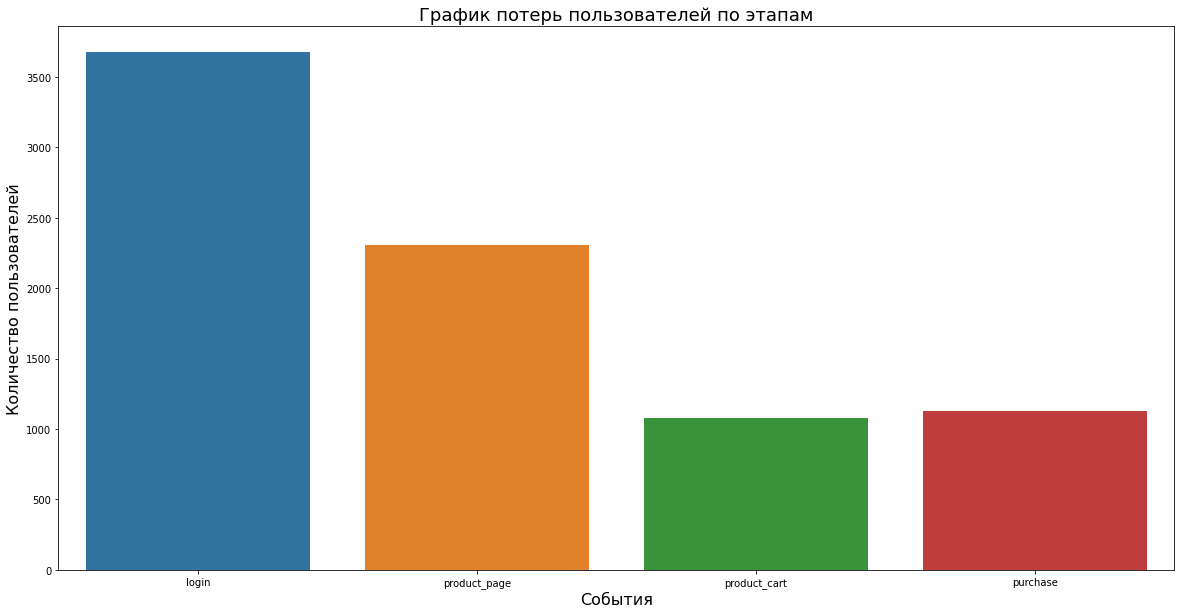

In [66]:
plt.figure(figsize =(20, 10))
sns.barplot(data=filt_user_per_event, x='event_name', y='user_id')
plt.title('График потерь пользователей по этапам', fontsize = 18)
plt.xlabel('События', fontsize = 16)
plt.ylabel('Количество пользователей', fontsize = 16)
plt.show()

In [67]:
#подготовка сводной таблицы для граика
pt_2 = pd.pivot_table(df, index = ['event_name','group'], values = ['user_id'], aggfunc={'nunique'})
pt_2.columns = pt_2.columns.droplevel(0)
pt_2 = pt_2.rename(columns={'device':'count'}).reset_index()

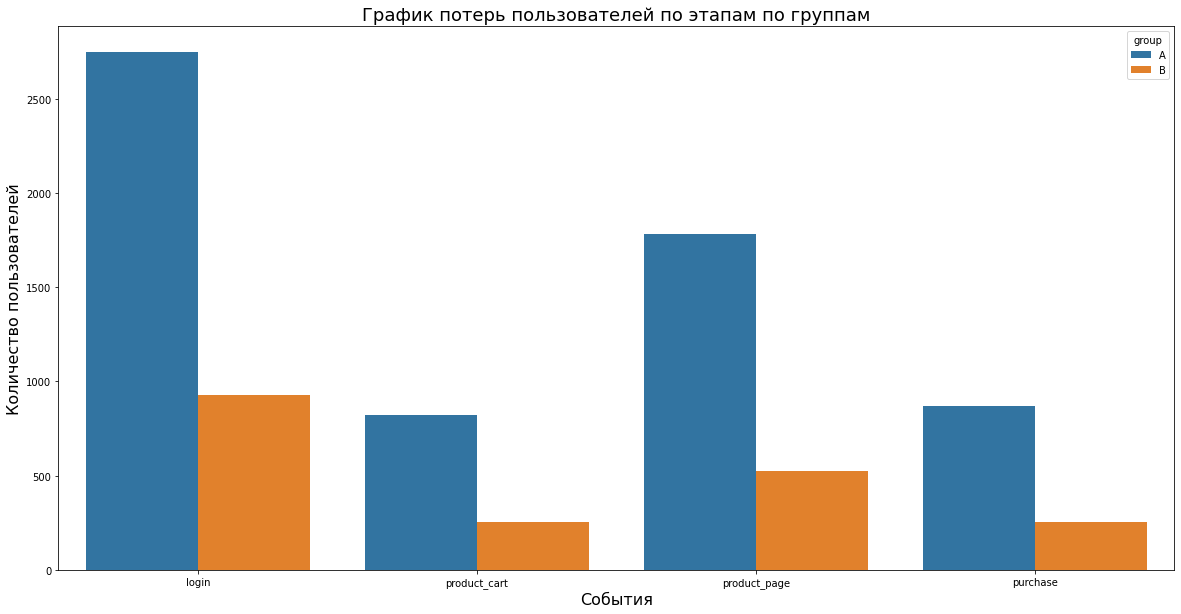

In [68]:
plt.figure(figsize =(20, 10))
sns.barplot(data=pt_2, x='event_name', y='nunique', hue='group')
plt.title('График потерь пользователей по этапам по группам', fontsize = 18)
plt.xlabel('События', fontsize = 16)
plt.ylabel('Количество пользователей', fontsize = 16)
plt.show()

<div style="text-align: justify ">
<b>Краткий вывод: </b> Как видно из графика и раннее проведенного анализа наибольшие потери наблюдаются при переходе с логина  на страницу продукта (около 37%). По группам наблюдается такая же тенденция. Также из второго графика хорошо видно, насколько большая разница между группами.

<u><b> Подсчет доли пользователей, которые доходит от первого события до оплаты

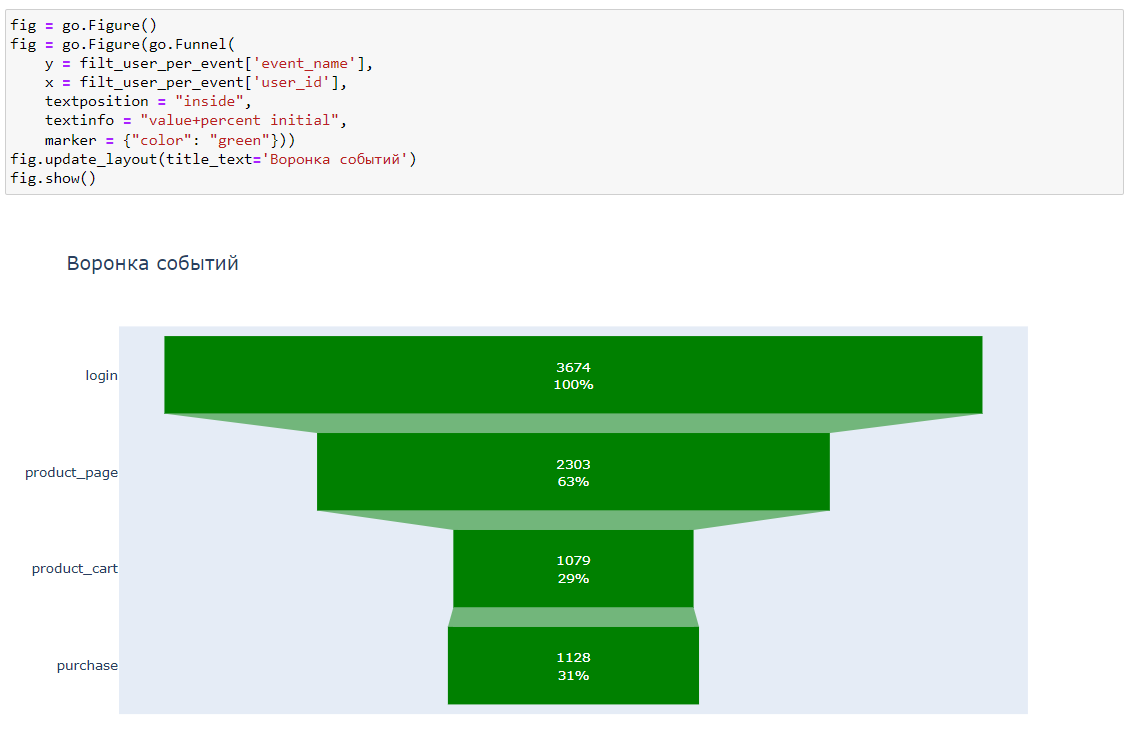

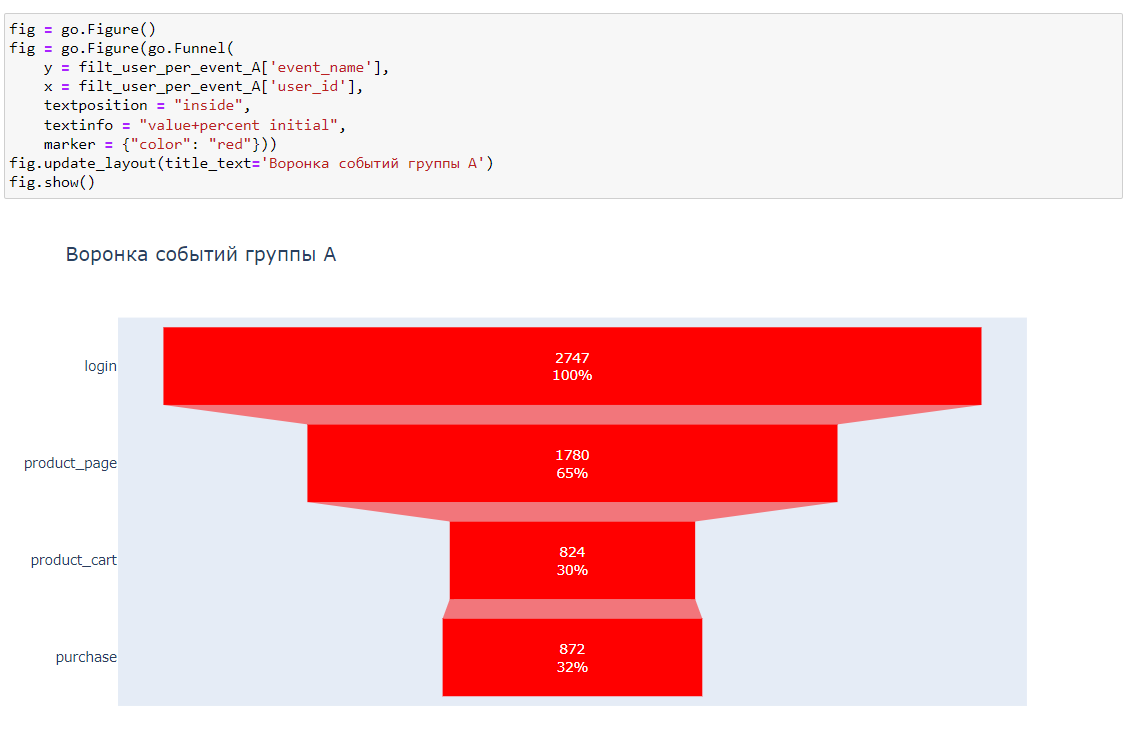

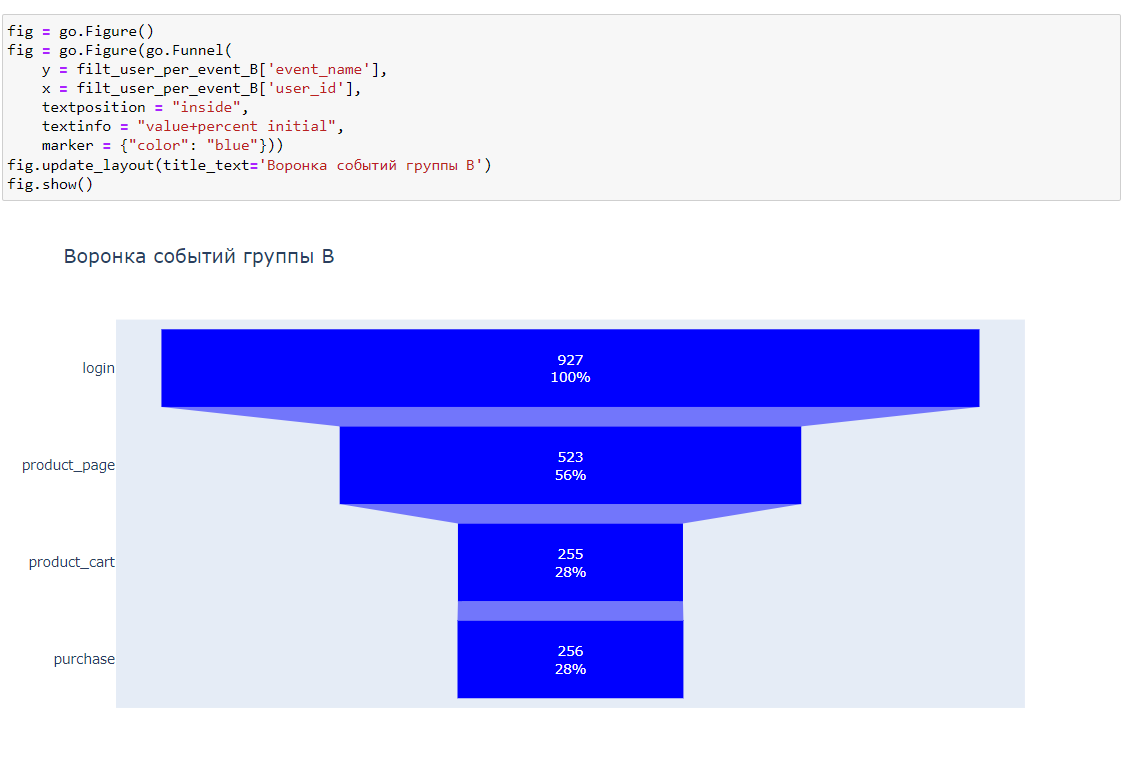

<div style="text-align: justify ">
<b>Краткий вывод: </b> Из построенной воронки событий и проведенного раннее анализа видно, что после логина до страницы с оплатой доходят 31% пользователей. У группы А такой процент выше - 32%, у группы В наоборот ниже. Хотя корзину просматривают меньше, но в группе процент просмотра корзины такой же, как и у покупки - 28%.

<div style="text-align: justify ">
<b>Вывод: </b> Всего пользователи проходят 4 этапа событий: логин, страница продукта, корзина и оплата. Почти 100% производят логин. Больше всего пользователей теряется при преходе на страницу продукта (37%). Такая же тенденция наблюдается и среди групп отдельно. До страницы с оплатой доходит 32% пользователей. Инетресным является факт, что процент у страницы просмотра корзины меньше, чем у страницы с оплатой.
При детальном рассмотрении каждой группы теста можнно отметить, что процент удержания пользователей группы В ниже, чем у группы А - на страницу продукта группы В переходит 56% пользователей, у группы А - 65%, на страницу корзины у группы В - 27%, у группы А - 30%, покупку совершают 28% пользователей группы В и 32% группы А. 

### 5. Проведение и оценка A/B-тестирования

На предыдуших этапах исследования уже было установлено, что пользователи распределены между группами А и В не равномерно.

In [72]:
df_z = df.groupby('group')['user_id'].nunique().reset_index()
df_z

,group,user_id
0,A,2747
1,B,928


In [73]:
#создадим сводную таблицу с числом пользователей по каждому событию и распределнию по группам
pt = df.pivot_table(index='event_name', columns='group',values='user_id',aggfunc='nunique')
pt

group,A,B
event_name,,
login,2747,927
product_cart,824,255
product_page,1780,523
purchase,872,256


<div style="text-align: justify ">
Для проверки статистических критериев между группами подготовим функцию Z теста, так как выполнятся тест быдет не один раз. Также внесем поправку к уровням значимости, так как мы будем проводить мнонжественный тест. Для этого воспользуемся методом Бонферрони: уровни значимости в каждом из m сравнений в m раз меньше, чем уровень значимости, требуемый при единственном сравнении. Всего будет проведено 4 теста.

In [74]:
#функция для статистической значимости

def z_test(gr_1, gr_2, event_name, alpha):
     
        p1_logs = pt.loc[event_name, gr_1]
        p2_logs = pt.loc[event_name, gr_2]
        
        p1_users = df_z.loc[df_z['group'] == gr_1, 'user_id'].values[0]
        p2_users = df_z.loc[df_z['group'] == gr_2, 'user_id'].values[0]
        
        p1 = p1_logs /  p1_users
        p2 = p2_logs /  p2_users
        
        print(p1_users, p2_users)
        
        p_combined = (p1_logs + p2_logs) / (p1_users + p2_users)
        
        difference = p1 - p2 
        
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/p1_users + 1/p2_users))
        
        distr = st.norm(0, 1) 
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        m_bonferroni = alpha/4
        
        print('Событие:', event_name)
        print('p_value:', p_value)
            
        if p_value < m_bonferroni:
            print('Отвергаем нулевую гипотезу')
        else:
            print('Не получилось отвергнуть нулевую гипотезу')
            
        print()    

Еще раз проверим данные на наличие пользователей в обеих группах

In [75]:
len(df.groupby('user_id')['group'].nunique().reset_index().query('group > 1'))

0

В выборки нет пользователей, которые попадали бы в несколько групп, можно приступать к выполнению теста.

Посчитаем статистическую значимость различий между группами А и В.

Нулевая $H_{0}$: значимых различий между долями нет, различия статистически не значимы. 

Альтернативная $H_{1}$: значимые различия между долями есть.

In [76]:
for event_name in pt.index:
    z_test('A', 'B', event_name, 0.05)

2747 928
Событие: login
p_value: 0.08529860212027773
Не получилось отвергнуть нулевую гипотезу

2747 928
Событие: product_cart
p_value: 0.14534814557238196
Не получилось отвергнуть нулевую гипотезу

2747 928
Событие: product_page
p_value: 4.310980554755872e-06
Отвергаем нулевую гипотезу

2747 928
Событие: purchase
p_value: 0.017592402663314743
Не получилось отвергнуть нулевую гипотезу



Для проверки статистических критериев значимости различий был выбран уровень значимости, равный 5 процентам. Было проведено 4 проверки статистических гипотез. Дополнительно был применен метод Бонферрони, т.к. тест был множественным.

Статистически значимых различий между событиями групп А и В по трем событиям не наблюдается. Можно утверждать, что значимые различия между долями групп А и В есть только по событию просмотр страницы товара. 

### 6. Итоги проведения А/В-теста

В ходе проведения исследовательского анализа было выявлено следующее:
- Всплеск активности происходит в период с 15.12 по 23.12 с пиком на 22.12, что вполне логично, т.к. тест проводиться для Европы и пользователи готовятся к Рождественским праздникам.
- Большинство пользователей совершают первые действие в первый день после регистрации независимо от группы теста.
- В среднем пользователь группы А совершает событий больше (почти 7 событий), чем пользователи группы В (5,5), медианное значение также выше - 6 против 4. Максимальное количество событий пользователей обеих групп равно 24.
- Распределение по устройствам группы А также сильно выше.
- При исследовании воронки событий было определено 4 события - самое популярное событие - регистрация (почти 100%), далее идет просмотр страницы (63%). После логина до страницы с оплатой доходят 31% пользователей. Интересным является факт, что покупка имеет больший процент посещения, чем просмотр корзины (29%). 

<div style="text-align: justify ">
По итогам проверки проведенного А/В-теста можно сделать вывод, что экспериментальная группа не достигла поставленной цели по улучшению каждой метрики не менее, чем на 10%. При проведение z-теста было отмечено, что статистически значимых различий между событиями групп А и В по трем действиям не наблюдается. Значимые различия между долями групп А и В имеются только по событию просмотр страницы товара. Таким образом результаты проведенного тестирования можно считать не удовлетворительными, поставленные цели достигнуты не были.<br>
Важно отметить, что период проведения теста выбран крайне неудачным, т.к. это время подготовки к Рождеству. Кроме того даты окончания теста не соответствуют заявленным в ТЗ датам. Желаемый процент новых пользователей из Европы - 8,22%, что почти в 2 раза меньше заявленной в ТЗ (15%). Ожидаемое количество участников также сильно ниже ожидаемых - чуть более 3,5 тыс. пользователей. Разница между количеством пользователей групп достаточно большая. Кроме того, во время прохождения теста проходила рождественская акция. Также параллельно проходил еще один тест. Все эти факторы могли сказаться на результатах проведения А/В-теста.

### 7. Общий вывод по проекту

<b><i>1) В части ознакомления данных</i></b><br><br>
Для анализа предоставлены 4 датасета:
- <b>Календарь маркетинговых событий на 2020 год</b> содержит  14 мероприятий, явных дубликатов и пропусков не обнаружено.<br>
- Масси данных о <b>пользователях, зарегистрировавшиеся с 7 до 21 декабря 2020 года</b> содержит информацию о 617330 участниках, явных дубликатов и пропусков также не обнаружено.<br>
- Данные о <b>действиях новых пользователей в период с 7 декабря 2020 по 4 января 2021 года</b> содержит информацию о 440317 действий, явных дубликатов не обнаружено, имеется большой процент пропусков (86%) по столбцу <b>details</b>, но т.к. данная информация не является обязательной для заполнения и необходимой для анализа, прорабатывать дополнительно и заполнять/удалять такие пропуски не будем.<br>
- <b>Таблица участников тестов</b> содержит 18 268 пользователей, явных дубликатов и пропусков не обнаружено.

<b><i>2) В части предобработки данных</i></b><br>
- в ходе предобработки данных неявных дубликатов обнаружено не было, среди новых пользователей повторений нет.  Были изменены форматы столбцов по всем массивам, содержащие информацию о дате. Таким столбцам был присвоен тип `data`.

<b><i>3) В части проверки технического задания</i></b><br>
- начало проведения теста совпадает с началом регистрации новых пользователей и соответствует ТЗ;
- дата окончания регистрации также соответствует заявленному в ТЗ. Однако время окончания теста, заявленного в ТЗ, не соответствует дате последнего события, сделанного пользователем, возможно это связано с Рождественскими праздниками;
- была проведена фильтрация по периоду проведения теста. Пользователи, которые совершили первое событие после 14 дней, были отсечены;
- после фильтрации по периоду проведения исследования, в тесте принимают участие 3 675 пользователей, что меньше ожидаемого. Большая часть участников из Европы. Доля новых пользователей региона EU составляет 14,48%, что  также не соответствует заявленной доли в ТЗ;
- в ходе проверки пересечения участия пользователей в двух тестах было обнаружено, что в обоих тестах участвуют 1602 пользователя. В группе В конкурирующего теста принимали участие 783 пользователя. Распределение таких пользователей на группы А и В контрольного теста равномерное, удалять таких пользователей не стали;
- пересечение среди участников групп А и В контрольного теста не обнаружено.

<b><i>4) В части исследовательского анализа данных</i></b><br>
- всплеск активности происходит в период с 15.12 по 23.12 с пиком на 22.12, большинство пользователей совершают первое событие в первый же день, независимо от группы теста.
- В первый день новых пользователей больше по группе В, однако, начиная со второго дня новых пользователей группы А стабильно больше. Пик набора новых пользователей группы В приходится на 07.12, группы А на 14.12, причем он почти в два раза больше. После 16.12 регистрация новых пользователей идет ровно. Количество новых пользователей группы А в разы превышает количество группы В.
- В среднем пользователь группы А совершает событий больше (почти 7 событий), чем пользователи группы В (5,5), медианное значение также выше - 6 против 4. Максимальное количество событий пользователей обеих групп равно 24.
- Распределение по устройствам группы А также сильно выше.
- <div style="text-align: justify "> При исследовании воронки событий было определено 4 события - самое популярное событие - регистрация (почти 100%), далее идет просмотр страницы (63%). После логина до страницы с оплатой доходят 31% пользователей. акая же тенденция наблюдается и среди групп отдельно. До страницы с оплатой доходит 32% пользователей. Инетресным является факт, что процент у корщины меньше, чем у страницы с оплатой.
При детальном рассмотрении каждой группы теста можнно отметить, что процент удержания пользователей группы В ниже, чем у группы А - на страницу продукта группы В переходит 56% пользователей, у группы А - 65%, на страницу корзины у группы В - 27%, у группы А - 30%, покупку совершают 28% пользователей группы В и 32% группы А. 

<b><i>5) В части проверки гипотез</i></b><br><br>
<div style="text-align: justify ">
По итогам проверки проведенного А/В-теста можно сделать вывод, что экспериментальная группа не достигла поставленной цели по улучшению каждой метрики не менее, чем на 10%. При проведение z-теста было отмечено, что статистически значимых различий между событиями групп А и В по трем действиям не наблюдается. Значимые различия между долями групп А и В имеются только по событию просмотр страницы товара. Таким образом результаты проведенного тестирования можно считать не удовлетворительными, поставленные цели достигнуты не были.<br>
Важно отметить, что период проведения теста выбран крайне неудачным, т.к. это время подготовки к Рождеству. Кроме того даты окончания теста не соответствуют заявленным в ТЗ датам. Желаемый процент новых пользователей из Европы - 8,22%, что почти в 2 раза меньше заявленной в ТЗ (15%). Ожидаемое количество участников также сильно ниже ожидаемых - чуть более 3,5 тыс. пользователей. Разница между количеством пользователей групп достаточно большая. Кроме того, во время прохождения теста проходила рождественская акция. Также параллельно проходил еще один тест. Все эти факторы могли сказаться на результатах проведения А/В-теста.